In [1]:
from cell import Cell
import cells_extractor 
import visualizer
from cell_event import CellEvent, CellDefine, Cell

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.colors import ListedColormap
from PIL import Image
import string
import cv2
import os
import matplotlib.patches as patches
import glob
import networkx as nx

In [3]:
from visualizer import CELL_EVENT_COLOR
from cell_event import CellEvent

In [4]:
mask = cells_extractor.get_omnipose_mask_dict("/Users/sherryyang/Documents/wiggins-lab/data/1023/xy5/masks/*.png")
cells, error = cells_extractor.get_cells_set_by_mask_dict(mask)

In [5]:
reader1 = LinkReader(cells)

In [6]:
G_new = reader1.make_new_dircted_graph()

In [51]:
G_new.add_edge(Cell(117, 60), Cell(129, 34))

G_new.add_edge(Cell(129, 34), Cell(140, 13))
G_new.add_edge(Cell(129, 34), Cell(140, 15))

In [ ]:
quick_lieage(G_new)

In [5]:
reader = LinkReader(cells)

In [6]:
spots_filename = "/Users/sherryyang/Documents/wiggins-lab/data/spots-simple.csv"
edge_filename = "/Users/sherryyang/Documents/wiggins-lab/data/tracks-simple.csv"
G_trackmate = reader.abstract_trackmate_linking_result(spots_filename, edge_filename)

In [7]:
spots_filename = "/Users/sherryyang/Documents/wiggins-lab/data/spots_kalman_lap_1115.csv"
edge_filename = "/Users/sherryyang/Documents/wiggins-lab/data/tracks_kalman_lap_1115.csv"
G_kalman = reader.abstract_trackmate_linking_result(spots_filename, edge_filename)

In [8]:
read = LinkReader(cells)
G = read.make_new_dircted_graph()
dict = read.cells_frame_dict
sorted_frame = sorted(dict)

for i in range(1, len(sorted_frame)):
    source_frame = dict[sorted_frame[i-1]]
    target_frame =  dict[sorted_frame[i]]
    for cell in target_frame:
        max_IoU = 0
        best_candidate = None
        for cell_candicate in source_frame:
            intersect = cell.polygon.intersection(cell_candicate.polygon).area 
            union = cell.polygon.union(cell_candicate.polygon).area 
            IoU = intersect * 1.0 / union
            if IoU  > max_IoU:
                max_IoU  = IoU
                best_candidate = cell_candicate
        if best_candidate is not None:
            G.add_edge(best_candidate, cell)

    for cell in source_frame:
        if G.out_degree(cell) == 0:
            max_IoU = 0
            best_candidate = None
            for cell_candicate in target_frame:
                intersect = cell.polygon.intersection(cell_candicate.polygon).area 
                union = cell.polygon.union(cell_candicate.polygon).area 
                IoU = intersect * 1.0 / union
                if IoU  > max_IoU:
                    max_IoU  = IoU
                    best_candidate = cell_candicate
            if best_candidate is not None:
                G.add_edge(cell, best_candidate)


In [ ]:

tag = visualizer.tag_type(G)
pos = visualizer.get_lineage_pos(G)

node_special = {CELL_EVENT_COLOR[CellEvent.BIRTH]: tag[CellEvent.BIRTH], CELL_EVENT_COLOR[CellEvent.DIE]: tag[CellEvent.DIE]}
edge_special = {CELL_EVENT_COLOR[CellEvent.SPLIT]: tag[CellEvent.SPLIT], CELL_EVENT_COLOR[CellEvent.MERGE]: tag[CellEvent.MERGE]}

visualizer.plot_lineage(G, pos, with_background = True , nodes_special = node_special, edges_special = edge_special)

In [28]:
def quick_lieage(G):
    tag = visualizer.tag_type(G)
    pos = visualizer.get_lineage_pos(G)

    node_special = {CELL_EVENT_COLOR[CellEvent.BIRTH]: tag[CellEvent.BIRTH], CELL_EVENT_COLOR[CellEvent.DIE]: tag[CellEvent.DIE]}
    edge_special = {CELL_EVENT_COLOR[CellEvent.SPLIT]: tag[CellEvent.SPLIT], CELL_EVENT_COLOR[CellEvent.MERGE]: tag[CellEvent.MERGE]}

    visualizer.plot_lineage(G, pos, with_background = True , nodes_special = node_special, edges_special = edge_special)

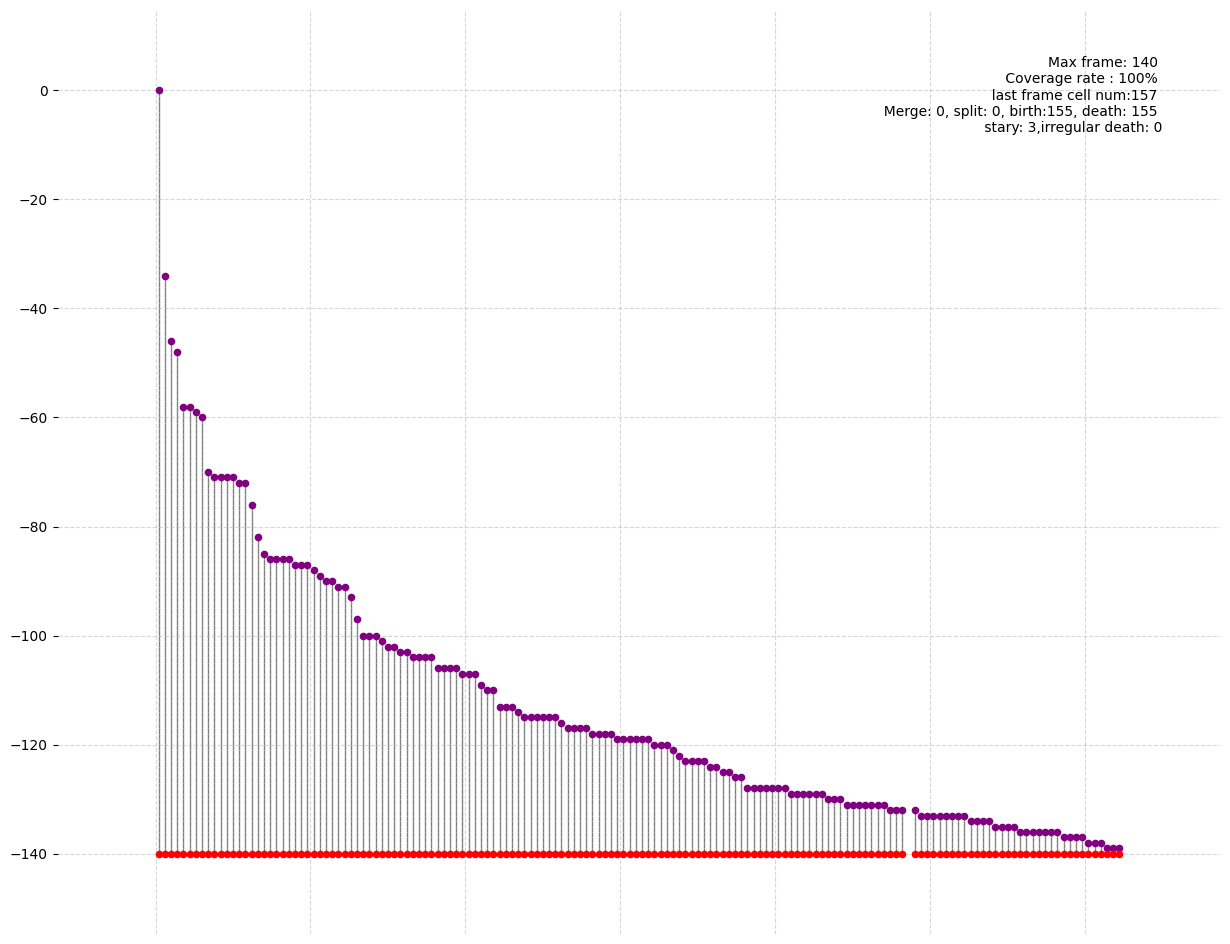

In [29]:
quick_lieage(G_kalman)

In [ ]:
quick_lieage(G_trackmate)

In [9]:
Glist = {"a.simple advance overlap": G , "a.trackmate overlap": G_trackmate, "b.trackmate kalman": G_kalman}

In [13]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
import os
import glob

def make_multi_case_visualization(base_dir, Glist, circle_label=False, representative_point=False):
    
    video_dir = os.path.join(base_dir, "video")
    os.makedirs(video_dir, exist_ok=True)

    
    filename = "*.tif"
    file_path = os.path.join(base_dir, filename)
    files = glob.glob(file_path)
    files.sort()

    n_cases = len(Glist)
    G_index = sorted(Glist)

    tag_dic = {} 
    info_dic = {}
    pos_dic = {}

    for name, G in Glist.items():
        tag_dic[name] = visualizer.tag_type(G)
        info_dic[name] = visualizer.get_label_info(G)
        pos_dic[name] = visualizer.get_lineage_pos(G)

    # Master figure setup
    fig = plt.figure(figsize=(8 * n_cases, 10))  # Adjust the size as needed
    gs = gridspec.GridSpec(2, n_cases, height_ratios=[1, 5])  # 2 rows, n_cases columns
    reader = LinkReader(Glist[G_index[1]])

    #gs = gridspec.GridSpec(2, 1, height_ratios=[1, 5]) 
    for frame in range(120,123):
        file = files[frame]
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        output_path = os.path.join(video_dir, f"frame{frame:05d}.png")
        for i in range(len(G_index)):
            name = G_index[i]
            print(name)
            G = Glist[name]
            
            tag = tag_dic[name]
            info = info_dic[name]
            pos = pos_dic[name]

            # First subplot for the image
            ax1 = fig.add_subplot(gs[1, i])
            ax1.imshow(image)
            ax1 = visualizer.get_single_frame_visualization(ax1, image, reader.cells_frame_dict, info, frame, circle_label, representative_point)
            ax1.set_axis_off() 
            ax1.set_title(name) 

            cell_s, edge_s, pos1 = visualizer.get_lineage_info_for_single_frame(G, frame, tag)
            # Second subplot for the lineage graph
            ax2 = fig.add_subplot(gs[0, i])
            ax2 = visualizer.sub_plot_lineage(ax2, G, pos, with_background=False, nodes_special=cell_s, edges_special=edge_s, arrow=True, show_stat=False)
            ax2.set_frame_on(False)

        plt.tight_layout()
        #plt.show()
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0, transparent=False)

        # Optionally save the entire figure
        #plt.savefig("master_plot.png", bbox_inches='tight', pad_inches=0, transparent=True)

# Call the function
#make_multi_case_visualization(G, base_dir, n_cases=5, circle_label=True, representative_point=True)


In [43]:
import matplotlib.ticker as ticker

def sub_plot_lineage(ax, G, pos, with_background = False, nodes_special = None, edges_special = None, show_stat = True, figsize = (15,12), arrow = False):
    node_list = list(G.nodes())
    node_list.sort()

    # draw background
    if with_background: 
        nx.draw(G, pos, node_size = 0,  width=1, edge_color="grey", arrows = arrow, ax=ax)
    if nodes_special != None:
        for color, nodes in nodes_special.items():
            nx.draw_networkx_nodes(G, pos, nodelist=list(nodes), node_size=20, node_color=color, ax=ax)
        for color, edges in edges_special.items():
            nx.draw_networkx_edges(G, pos, edgelist=edges , width=2, edge_color=color, arrows= arrow, ax=ax)

    # Styling stuff below
    ax.set_frame_on(False)
    ax.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False)

    def format_fn(tick_val, tick_pos):
        if tick_val % 1 == 0:
            return f"frame {int(abs(tick_val))}"
        else:
            return ""
        #return f"frame {int(abs(tick_val))}" if tick_val.is_integer() else ""

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_fn))

    limits=plt.axis('on')
    if show_stat:
        text = visualizer.get_graph_stats_text(G)
        ax.text(0.95, 0.95,  text, transform=ax.transAxes, horizontalalignment='right', verticalalignment='top')
        
    ax.grid(True, linestyle='--', alpha=0.5)

    return ax

In [48]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
import os
import glob

def make_single_thread_visualization(base_dir, Glist, frame, circle_label=False, representative_point=False):
    
    video_dir = os.path.join(base_dir, "video")
    os.makedirs(video_dir, exist_ok=True)

    
    filename = "*.tif"
    file_path = os.path.join(base_dir, filename)
    files = glob.glob(file_path)
    files.sort()

    n_cases = len(Glist)
    G_index = sorted(Glist)

    tag_dic, info_dic, pos_dic = {}, {}, {}
    for name, G in Glist.items():
        tag_dic[name] = visualizer.tag_type(G)
        info_dic[name] = visualizer.get_label_info(G)
        pos_dic[name] = visualizer.get_lineage_pos(G)

    # Master figure setup
    fig = plt.figure(figsize=(8 * n_cases, 10))  # Adjust the size as needed
    plt.axis('off')
    gs = gridspec.GridSpec(2, n_cases, height_ratios=[1, 5])  # 2 rows, n_cases columns
    composer = LinkComposer(Glist[G_index[1]])

    #gs = gridspec.GridSpec(2, 1, height_ratios=[1, 5]) 

    file = files[frame]
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    output_path = os.path.join(video_dir, f"frame{frame:05d}.png")
    for i in range(len(G_index)):
        name = G_index[i]
        G = Glist[name]
        
        tag = tag_dic[name]
        info = info_dic[name]
        pos = pos_dic[name]

        # First subplot for the lineage
        cell_s, edge_s, pos_even = visualizer.get_lineage_info_for_single_frame(G, frame, tag)
       
        ax2 = fig.add_subplot(gs[0, i])
        ax2 = sub_plot_lineage(ax2, G, pos, with_background=False, nodes_special=cell_s, edges_special=edge_s, arrow=True, show_stat=False)
        ax2.set_frame_on(False)
        ax1.set_axis_off() 

        # Second subplot for fluorescent image
        ax1 = fig.add_subplot(gs[1, i])
        ax1.imshow(image)
        ax1 = visualizer.get_single_frame_visualization(ax1, image, composer.cells_frame_dict, info, frame, circle_label, representative_point)
        ax1.set_axis_off() 
        ax1.set_title(name) 

    #plt.tight_layout()
    #plt.show()
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0, transparent=False)

In [45]:
base_dir = "/Users/sherryyang/Documents/wiggins-lab/data/1024/xy5/phase"
#make_multi_case_visualization(base_dir, Glist)

In [46]:
import threading

/var/folders/tp/1bsthy355yj6qlmh5ym1996w0000gn/T/ipykernel_21721/750073827.py:14: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edgelist=edges , width=2, edge_color=color, arrows= arrow, ax=ax)


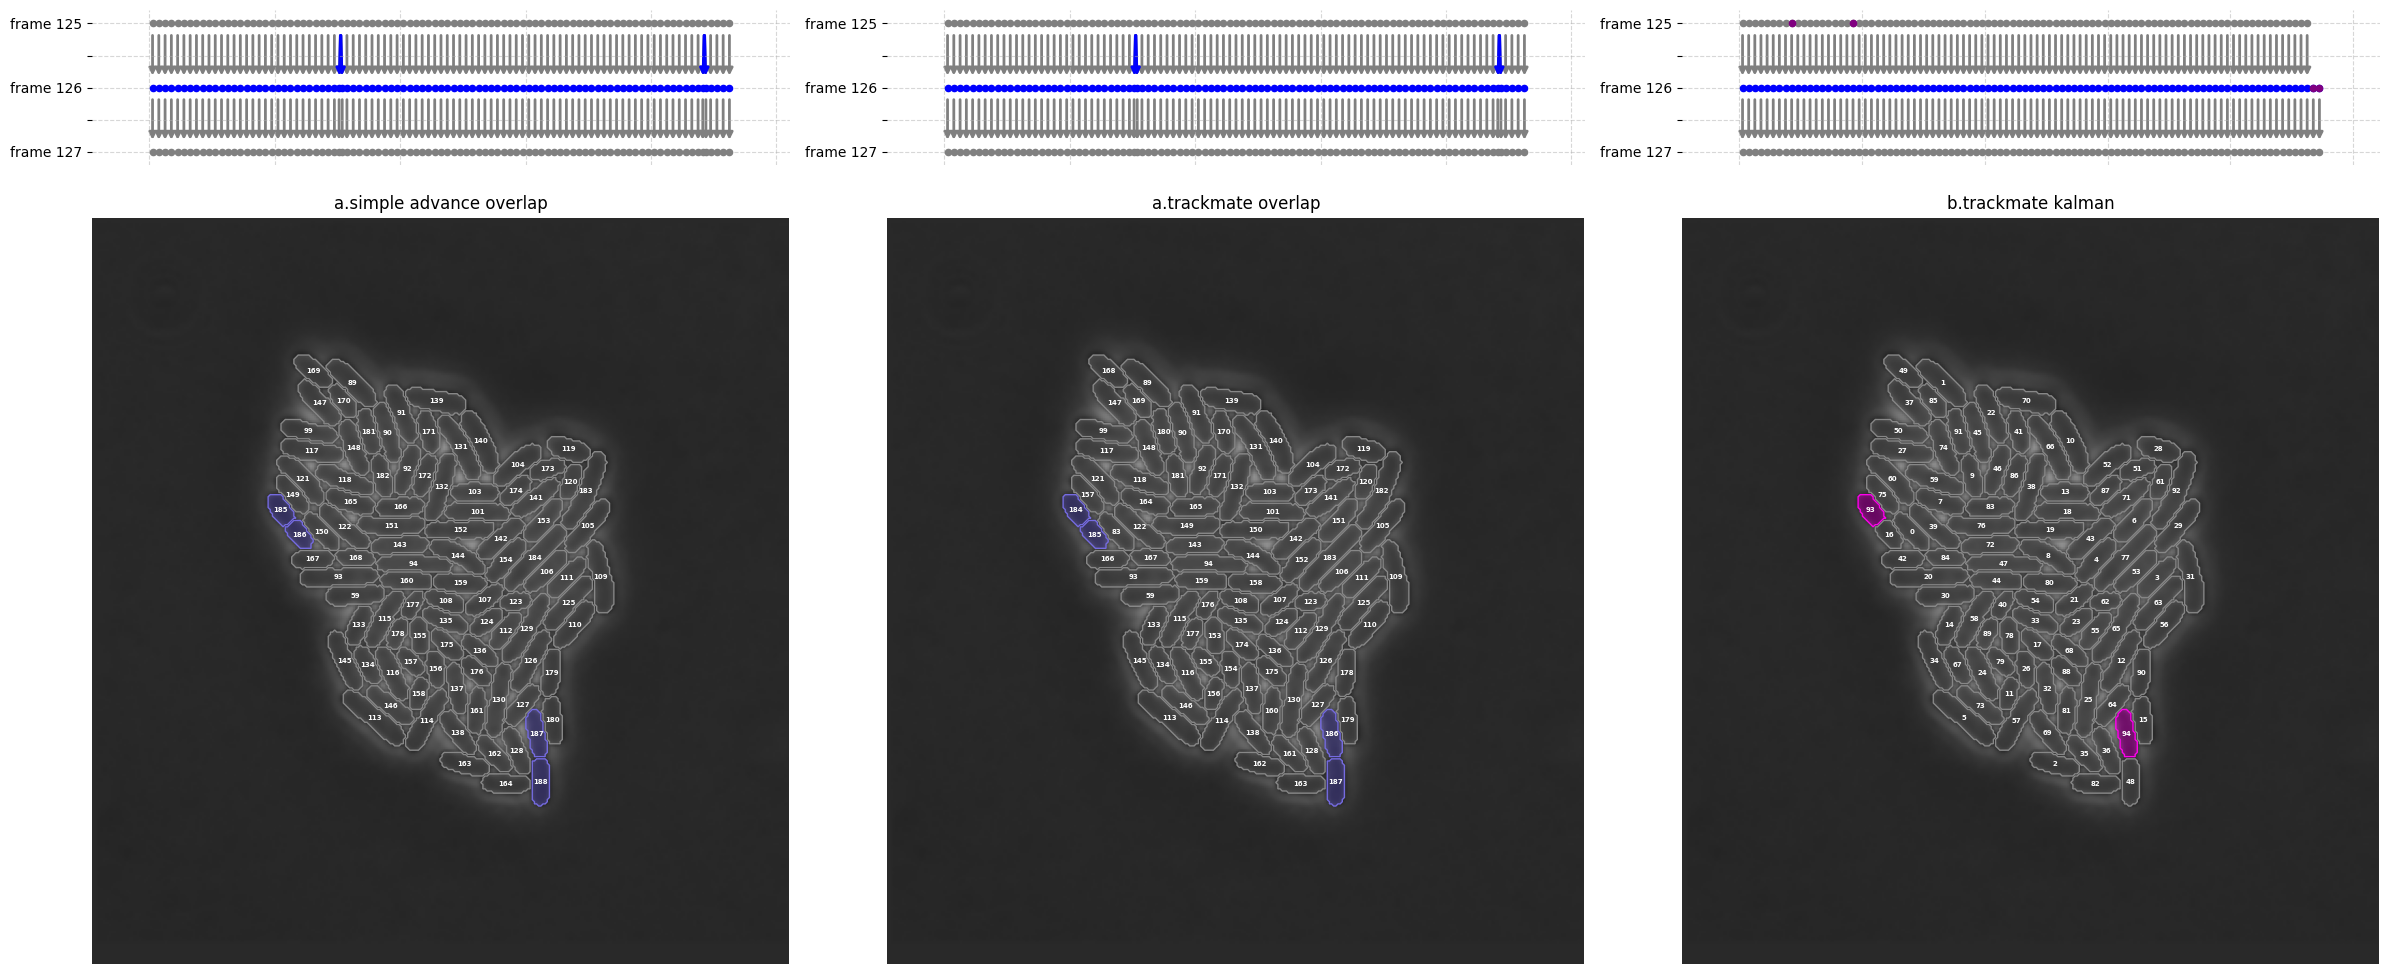

In [47]:
make_single_thread_visualization(base_dir, Glist, 126)

In [ ]:
for i in range(141):
    make_single_thread_visualization(base_dir, Glist, i)

In [26]:
list = list(cells)
list.sort()

In [27]:
list[-1].frame

140

In [33]:
visualizer.image_to_tif_sequence("/Users/sherryyang/Documents/wiggins-lab/data/1024/xy5/phase")


IndexError: list index out of range

In [ ]:
info = visualizer.get_label_info(G)
visualizer.get_single_track_visualization(G, base_dir,info)